In [2]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Utils 

In [48]:
def change_label(x):
    if x == "Long":
        return 1
    else:
        return 0

In [3]:
def clean_data(df):
    df = df[df["Date"].dt.weekday < 5].reset_index(drop = True)
    df.set_index("Date", inplace = True, drop = True)
    df = df.between_time("9:00", "16:00")
    df.reset_index(inplace = True)
    holidays = calendar().holidays(start = "1998-01-02",end = "2020-12-31") 
    mask = df["Date"].isin(holidays)
    newdf = df[~mask].copy()
    newdf = newdf.fillna(method = "ffill")
    return newdf

In [4]:
def label_data(x):
    if x["Close"] < x["Next Day Close"]: 
        return "Long"
    else:
        return "Short"

# Data

In [5]:
col_name = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"]
df = pd.read_csv("IBM_adjusted.txt", names=col_name, header = 0)
df.head()

,Date,Time,Open,High,Low,Close,Volume
0,01/02/1998,09:31,31.85,31.89,31.85,31.85,35388
1,01/02/1998,09:32,31.87,31.89,31.85,31.89,43580
2,01/02/1998,09:33,31.87,31.89,31.85,31.85,55048
3,01/02/1998,09:34,31.85,31.89,31.85,31.85,15731
4,01/02/1998,09:35,31.87,31.89,31.85,31.85,76346


In [6]:
df.isna().sum()

Date      0
Time      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [7]:
df.drop(["High", "Low", "Volume"], axis = 1, inplace = True)
df.head()

,Date,Time,Open,Close
0,01/02/1998,09:31,31.85,31.85
1,01/02/1998,09:32,31.87,31.89
2,01/02/1998,09:33,31.87,31.85
3,01/02/1998,09:34,31.85,31.85
4,01/02/1998,09:35,31.87,31.85


In [8]:
df["Date"] = pd.to_datetime(df["Date"] + " " + df["Time"])

In [9]:
df.drop(["Time"], axis = 1, inplace = True)
df.head()

,Date,Open,Close
0,1998-01-02 09:31:00,31.85,31.85
1,1998-01-02 09:32:00,31.87,31.89
2,1998-01-02 09:33:00,31.87,31.85
3,1998-01-02 09:34:00,31.85,31.85
4,1998-01-02 09:35:00,31.87,31.85


In [10]:
df.to_csv("data_ready.csv")

In [11]:
len(df)

2436174

In [12]:
df = df.groupby(pd.Grouper(key = "Date", freq = "1h")).mean().reset_index()
df.head()

,Date,Open,Close
0,1998-01-02 09:00:00,31.910000,31.914828
1,1998-01-02 10:00:00,31.883220,31.884746
2,1998-01-02 11:00:00,32.014576,32.015085
3,1998-01-02 12:00:00,32.043966,32.045517
4,1998-01-02 13:00:00,32.032000,32.033000


In [13]:
len(df)

204371

In [14]:
df["Open"] = df["Open"].replace(to_replace = 0, method = "ffill")

df["Close"] = df["Close"].replace(to_replace = 0, method = "ffill")
df.head()

,Date,Open,Close
0,1998-01-02 09:00:00,31.910000,31.914828
1,1998-01-02 10:00:00,31.883220,31.884746
2,1998-01-02 11:00:00,32.014576,32.015085
3,1998-01-02 12:00:00,32.043966,32.045517
4,1998-01-02 13:00:00,32.032000,32.033000


In [15]:
cleandf = clean_data(df)
cleandf

,Date,Open,Close
0,1998-01-02 09:00:00,31.910000,31.914828
1,1998-01-02 10:00:00,31.883220,31.884746
2,1998-01-02 11:00:00,32.014576,32.015085
3,1998-01-02 12:00:00,32.043966,32.045517
4,1998-01-02 13:00:00,32.032000,32.033000
...,...,...,...
48651,2021-04-26 12:00:00,142.703843,142.703290
48652,2021-04-26 13:00:00,142.275947,142.269082
48653,2021-04-26 14:00:00,141.966905,141.963307
48654,2021-04-26 15:00:00,141.807362,141.803703


In [16]:
cleandf["Next Day Close"] = cleandf["Close"].shift(-1)
cleandf.dropna(inplace = True)
cleandf.head()

,Date,Open,Close,Next Day Close
0,1998-01-02 09:00:00,31.910000,31.914828,31.884746
1,1998-01-02 10:00:00,31.883220,31.884746,32.015085
2,1998-01-02 11:00:00,32.014576,32.015085,32.045517
3,1998-01-02 12:00:00,32.043966,32.045517,32.033000
4,1998-01-02 13:00:00,32.032000,32.033000,31.925185


In [17]:
cleandf["Label"] = cleandf.apply(lambda x: label_data(x), axis = 1)
cleandf.head()

,Date,Open,Close,Next Day Close,Label
0,1998-01-02 09:00:00,31.910000,31.914828,31.884746,Short
1,1998-01-02 10:00:00,31.883220,31.884746,32.015085,Long
2,1998-01-02 11:00:00,32.014576,32.015085,32.045517,Long
3,1998-01-02 12:00:00,32.043966,32.045517,32.033000,Short
4,1998-01-02 13:00:00,32.032000,32.033000,31.925185,Short


In [18]:
cleandf.drop(["Next Day Close", "Close"], axis = 1, inplace = True)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = cleandf[cleandf["Date"] < "2017"]
test_data = cleandf[cleandf["Date"] >= "2017"]

In [78]:
len(test_data)

9007

In [128]:
x_train = train_data.drop(["Label"], axis = 1)
y_train = train_data["Label"]

In [129]:
x_train

,Date,Open
0,1998-01-02 09:00:00,31.910000
1,1998-01-02 10:00:00,31.883220
2,1998-01-02 11:00:00,32.014576
3,1998-01-02 12:00:00,32.043966
4,1998-01-02 13:00:00,32.032000
...,...,...
39643,2016-12-30 12:00:00,137.147500
39644,2016-12-30 13:00:00,137.042034
39645,2016-12-30 14:00:00,136.823500
39646,2016-12-30 15:00:00,136.694500


In [130]:
x_test = test_data.drop(["Label"], axis = 1)
y_test = test_data["Label"]

In [131]:
x_train_scaled = scaler.fit_transform(x_train["Open"].values.reshape(-1,1))

In [132]:
x_test_scaled = scaler.transform(x_test["Open"].values.reshape(-1,1))

# create/reshape data for prediction, each time use the previous 20 days. 

In [134]:
x_train_reshaped = []
y_train_reshaped = []
y_train_binary = y_train.apply(lambda x : change_label(x))
for i in range(20, len(x_train)):
    x_train_reshaped.append(x_train_scaled[i - 19: i + 1, 0])
    y_train_reshaped.append(y_train_binary[i])
x_train_reshaped = np.array(x_train_reshaped)
y_train_reshaped = np.array(y_train_reshaped)
print("x_train ", x_train_reshaped.shape)
print("y_train ", y_train_reshaped.shape)

x_train  (39628, 20)
y_train  (39628,)


# LSTM only accepts values in 3-dimensions, have to reshape the data 

In [135]:
x_train_reshaped = np.reshape(x_train_reshaped, (x_train_reshaped.shape[0], x_train_reshaped.shape[1], 1))

In [136]:
print("x_train ", x_train_reshaped.shape)

x_train  (39628, 20, 1)


# building LSTM neural net

In [137]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [138]:
model = Sequential()
model.add(LSTM(units = 100, activation = "tanh", return_sequences = True, input_shape = (x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, activation = "tanh"))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = "sigmoid"))


In [139]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [140]:
model.fit(x_train_reshaped, y_train_reshaped, epochs = 15, batch_size = 32, verbose = 1)

Epoch 1/15
1239/1239 [==============================] - 30s 22ms/step - loss: 0.6934 - accuracy: 0.5098
Epoch 2/15
1239/1239 [==============================] - 25s 20ms/step - loss: 0.6929 - accuracy: 0.5140
Epoch 3/15
1239/1239 [==============================] - 25s 20ms/step - loss: 0.6921 - accuracy: 0.5230
Epoch 4/15
1239/1239 [==============================] - 26s 21ms/step - loss: 0.6928 - accuracy: 0.5159
Epoch 5/15
1239/1239 [==============================] - 25s 21ms/step - loss: 0.6924 - accuracy: 0.5210
Epoch 6/15
1239/1239 [==============================] - 26s 21ms/step - loss: 0.6927 - accuracy: 0.5149
Epoch 7/15
1239/1239 [==============================] - 26s 21ms/step - loss: 0.6928 - accuracy: 0.5087
Epoch 8/15
1239/1239 [==============================] - 25s 20ms/step - loss: 0.6925 - accuracy: 0.5181
Epoch 9/15
1239/1239 [==============================] - 25s 21ms/step - loss: 0.6924 - accuracy: 0.5205
Epoch 10/15
1239/1239 [==============================] - 25s 20m

In [141]:
x_test_reshaped = []
y_test_reshaped = []
y_test_binary = y_test.apply(lambda x : change_label(x))
y_test_binary.reset_index(drop = True, inplace = True)
for i in range(20, len(x_test)):
    x_test_reshaped.append(x_test_scaled[i - 19: i + 1, 0])
    y_test_reshaped.append(y_test_binary[i])
x_test_reshaped = np.array(x_test_reshaped)
y_test_reshaped = np.array(y_test_reshaped)
print("x_test ", x_test_reshaped.shape)
print("y_test ", y_test_reshaped.shape)

x_test  (8987, 20)
y_test  (8987,)


In [142]:
x_test_reshaped = np.reshape(x_test_reshaped, (x_test_reshaped.shape[0], x_test_reshaped.shape[1], 1))

In [143]:
predictions = model.predict(x_test_reshaped)

In [144]:
predictions_label = np.where(predictions > 0.5, 1, 0)

In [145]:
accuracy_score(y_test_reshaped, predictions_label)

0.5195282074107044

# Attempt to predict price, transforming to regression problem

In [99]:
x_train_reshaped = []
y_train_reshaped = []
for i in range(20, len(x_train)):
    x_train_reshaped.append(x_train_scaled[i - 20: i, 0])
    y_train_reshaped.append(x_train_scaled[i, 0])
x_train_reshaped = np.array(x_train_reshaped)
y_train_reshaped = np.array(y_train_reshaped)
print("x_train ", x_train_reshaped.shape)
print("y_train ", y_train_reshaped.shape)

x_train  (39628, 20)
y_train  (39628,)


In [103]:
x_train_reshaped = np.reshape(x_train_reshaped, (x_train_reshaped.shape[0], x_train_reshaped.shape[1], 1))

In [104]:
model = Sequential()
model.add(LSTM(units = 100, activation = "tanh", return_sequences = True, input_shape = (x_train_reshaped.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, activation = "tanh", return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 25, activation = "tanh"))
model.add(Dropout(0.2))
model.add(Dense(units = 1))


In [105]:
model.compile(optimizer = "adam", loss = "mse")

In [106]:
model.fit(x_train_reshaped, y_train_reshaped, epochs = 25, batch_size = 32, verbose = 1)

Epoch 1/25
1239/1239 [==============================] - 30s 21ms/step - loss: 0.0081
Epoch 2/25
1239/1239 [==============================] - 26s 21ms/step - loss: 0.0018
Epoch 3/25
1239/1239 [==============================] - 26s 21ms/step - loss: 0.0012
Epoch 4/25
1239/1239 [==============================] - 26s 21ms/step - loss: 9.7148e-04
Epoch 5/25
1239/1239 [==============================] - 27s 22ms/step - loss: 0.0010
Epoch 6/25
1239/1239 [==============================] - 25s 21ms/step - loss: 9.4463e-04
Epoch 7/25
1239/1239 [==============================] - 25s 21ms/step - loss: 9.5801e-04
Epoch 8/25
1239/1239 [==============================] - 26s 21ms/step - loss: 9.7350e-04
Epoch 9/25
1239/1239 [==============================] - 25s 20ms/step - loss: 9.3536e-04
Epoch 10/25
1239/1239 [==============================] - 25s 20ms/step - loss: 9.3303e-04
Epoch 11/25
1239/1239 [==============================] - 25s 20ms/step - loss: 9.4472e-04
Epoch 12/25
1239/1239 [============

In [107]:
x_test_reshaped = []
y_test_reshaped = []
for i in range(20, len(x_test)):
    x_test_reshaped.append(x_test_scaled[i - 20: i, 0])
    y_test_reshaped.append(x_test_scaled[i, 0])
x_test_reshaped = np.array(x_test_reshaped)
y_test_reshaped = np.array(y_test_reshaped)
print("x_test ", x_test_reshaped.shape)
print("y_test ", y_test_reshaped.shape)

x_test  (8987, 20)
y_test  (8987,)


In [109]:
x_test_reshaped = np.reshape(x_test_reshaped, (x_test_reshaped.shape[0], x_test_reshaped.shape[1], 1))

In [110]:
predictions = model.predict(x_test_reshaped)

In [114]:
y_test_reshaped = scaler.inverse_transform(y_test_reshaped.reshape(-1,1))

In [116]:
predictions = scaler.inverse_transform(predictions.reshape(-1,1))

In [117]:
rmse = np.sqrt(mean_squared_error(y_test_reshaped, predictions))

In [118]:
rmse

1.1684769000492001

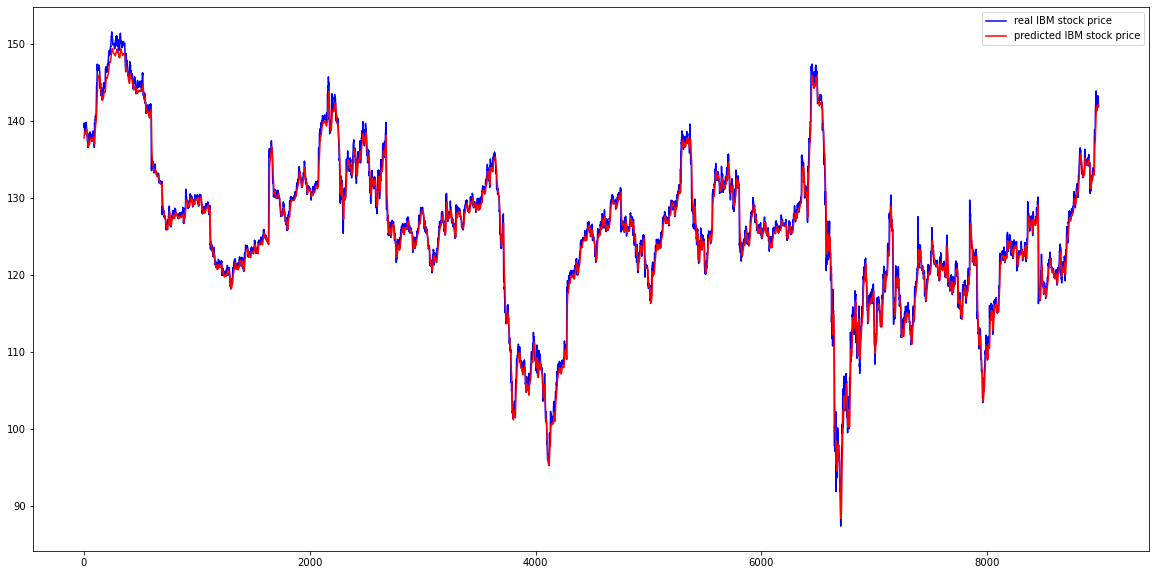

In [123]:
fig, ax = plt.subplots(1,1,figsize = (20, 10))
plt.plot(y_test_reshaped, color = "blue", label = "real IBM stock price")
plt.plot(predictions, color = "red", label = "predicted IBM stock price")
plt.legend()

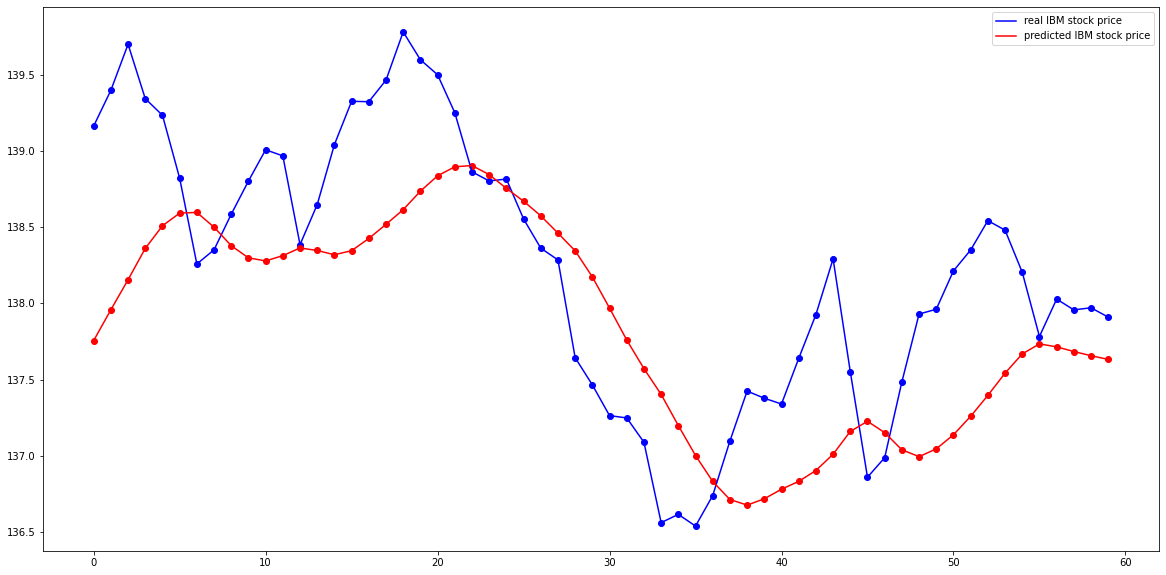

In [127]:
import matplotlib.pyplot as plt 
indices = np.arange(0, 60)
fig, ax = plt.subplots(1,1,figsize = (20, 10))
plt.plot(y_test_reshaped[:60], color = "blue", label = "real IBM stock price")
plt.scatter(indices, y_test_reshaped[:60], color = "blue")
plt.plot(predictions[:60], color = "red", label = "predicted IBM stock price")
plt.scatter(indices, predictions[:60], color = "red")
plt.legend()

# look for literature which suggests the accuracy is ~50%

# utilizing other indicators besides opening price may affect accuracy 